# MoBike Lyfecycle Prediction

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from sklearn.cluster import KMeans
from sklearn import metrics

# Table of Content:
* [0 Load Dataset](#0-Load-Dataset)
* [1 Data Preprocessing](#1-Data-Preprocessing)
  - [1.1 Trim Trip Duration](#1.1-Trim-Trip-Duration)
  - [1.2 Discover Lifecycle Interval](#1.2-Discover-Lifecycle-Interval)
    + [1.2.1 KMeans](#1.2.1-KMeans)
    + [1.2.2 Probability Value](#1.2.2-Probability-Value)
* [2 Data Analysis](#2-Data-Analysis)
  - [2.1 Current Feature Analysis](#2.1-Current-Feature-Analysis)
    + [2.1.1 Lifecycle VS Subscription Ratio](#2.1.1-Lifecycle-VS-Subscription-Ratio)
    + [2.1.2 Lifecycle VS Trips Number](#2.1.2-Lifecycle-VS-Trips-Number)
    + [2.1.3  Station VS Lifecycle](#2.1.3-Station-VS-Lifecycle)
    + [2.1.4 Station VS Crime](#2.1.4-Station-VS-Crime)
    + [2.1.5 Lifecycle VS Period](#2.1.5-Lifecycle-VS-Period)
    + [2.1.6 Lifecycle VS Parked Period](#2.1.6-Lifecycle-VS-Parked-Period)
  - [2.2 Weather](#2.2-Weather)
  - [2.3 Income](#2.3-Income)
  - [2.4 Education](#2.4-Education)
  - [2.5 Crime](#2.5-Crime)
  - [2.6 Finalize Dataset](#2.6-Finalize-Dataset)
* [3 Modeling](#3-Modeling)
  - [3.1 Linear Regression](#3.1-Linear-Regression)
    + [3.1.1 Fitting Model](#3.1.1-Fitting-Model)
    + [3.1.2 Error Analysis](#3.1.2-Error-Analysis)
  - [3.2 Random Forest](#3.2-Random-Forest)
    + [3.2.1 Fitting Model](#3.2.1-Fitting-Model)
    + [3.2.2 Error Analysis](#3.2.2-Error-Analysis)
  - [3.3 Neural Network](#3.3-Neural-Network)
    + [3.3.1 Fitting Model](#3.3.1-Fitting-Model)
    + [3.3.2 Error Analysis](#3.3.2-Error-Analysis)  
* [4 Conclusion](#4-Conclusion)

# 0 Load Dataset

In [54]:
# Load raw trip data
trip_bay = pd.read_csv('Dataset/bay_trip_city.csv', index_col=0)
station = pd.read_csv('Dataset/sf-station.csv')

# Lifecycle dataset is generated by section data preprocessing
lifecycle = pd.read_csv('Dataset/lifecycle_final.csv')

# 1 Data Preprocessing

## 1.1 Trim Trip Duration

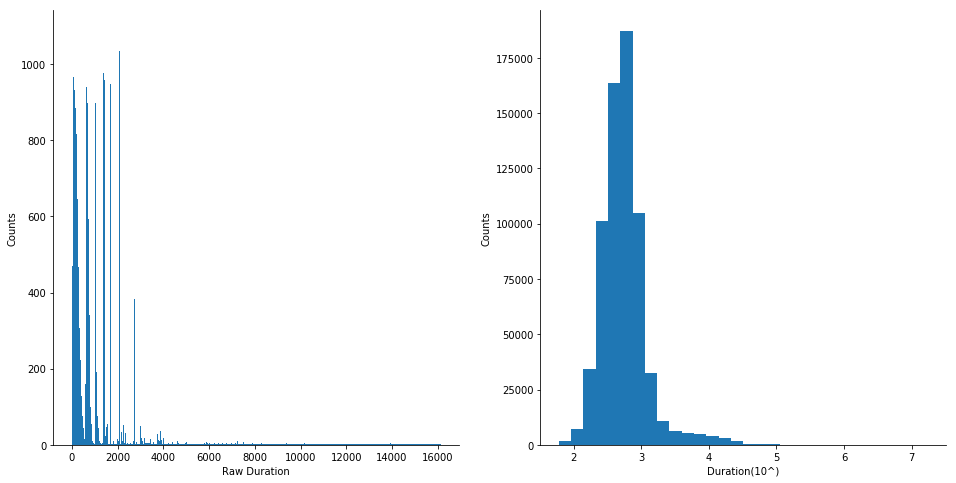

In [25]:
# Check trip duration distribution. We can see that the log data is like normal distribution

# Distribution with raw data
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
labels, values = zip(*Counter(trip_bay.duration).items())
indexes = np.arange(len(labels))
ax1.bar(indexes,values, 1)
plt.xlabel('Raw Duration')
plt.ylabel('Counts')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

## Distribution with log data 
interval_log = np.log10(np.array(trip_bay.duration))
ax2 = plt.subplot(122)
ax2.hist(interval_log, bins=30)
plt.xlabel('Duration(10^)')
plt.ylabel('Counts')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

In [30]:
# Based on the plots, we use logged data to trim trip duration in order to remove some outliers.
trip_mean = np.mean(interval_log)
trip_std = np.std(interval_log)

# Set up upbound and bottom bound. t1 is about 4 hours and t2 is about 2 mins.
t1 = np.mean(interval_log) + 2*np.std(interval_log)
t2 = np.mean(interval_log) - 2*np.std(interval_log)

# Trim raw trips data by t1 and t2
trip = trip_bay[(trip_bay.duration >= 120) & (trip_bay.duration <= 4*3600) ]

## 1.2 Discover Lifecycle Interval

### 1.2.1 KMeans

In [37]:
# Since there is no indicator for a bike's lifecycle, we start from using KMeans to group trips of each bike to try to 
# find lifecycle interval. Using Silhouette coefficient to find the optimal K for a specific bike.

def timedifference(row):
    """Calculate time difference between each trip of a specific bike.
    """
    startdifference = ((row['start_date']-initialstart)/np.timedelta64(1, 'h'))
    enddifference   = ((row['end_date']-initialend)/np.timedelta64(1, 'h'))
    return pd.Series((startdifference, enddifference))

def sil_cal_elbow(X, start, end):
    """Calculate silhouette coeff with different k.
    """
    result_list = []
    for n in range(start, end+1):
        kmeans = KMeans(n_clusters=n)
        p = kmeans.fit(X)
        t = metrics.silhouette_score(X, p.labels_)
        result_list.append(t)
    return result_list

def generatetraining(choose_id):
    """Generate subset based on bike id.
    """
    global initialstart
    global initialend
    test = trip[trip.bike_id == choose_id]
    test = test.sort_values('start_date')
    test['start_date']=pd.to_datetime(test['start_date'].values)
    test['end_date']=pd.to_datetime(test['end_date'].values)
    initialstart = test.iloc[0].start_date
    initialend   = test.iloc[0].end_date
    training_feature  = test.apply(timedifference, axis=1)
    training_feature.columns = ['start_diff', 'end_diff']
    return training_feature

def siloutteplot(training_feature):
    """Plot siloutte vs K.
    """
    t = sil_cal_elbow(training_feature, 2, 10)
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    x_axis=list(range(2,11))
    y_axis=t
    ax.plot(x_axis, t, 'b*-')
    plt.xlabel('K')
    plt.ylabel('Coefficient (1 is best, -1 is worst)')
    plt.title('Silhouette coefficient')
    plt.show()

    
def clusterplot(K, training_feature):
    """Plot clutered trips with optimal K.
    """
    km = KMeans(K)
    km.fit(training_feature)
    mu = km.cluster_centers_
    labels = km.labels_
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.scatter(training_feature['start_diff'], training_feature['end_diff'], c=labels, alpha=0.4)
    ax.scatter(mu[:,0], mu[:,1], s=300, c=np.unique(labels))
    plt.xlabel('start time')
    plt.ylabel('end time')
    plt.show()

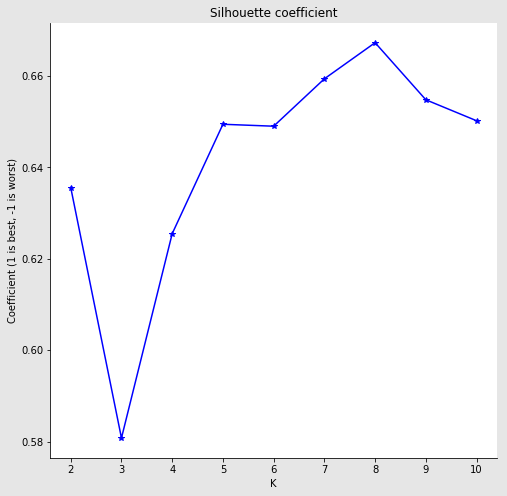

In [38]:
# KMeans with bike_id 9
training_feature = generatetraining(9)
siloutteplot(training_feature)

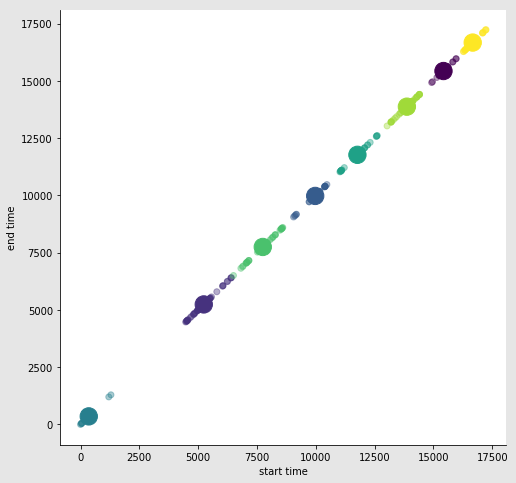

In [39]:
# The optimal K from the above plot is 8. And the clustering for bike id 9 is pretty good
clusterplot(8, training_feature)

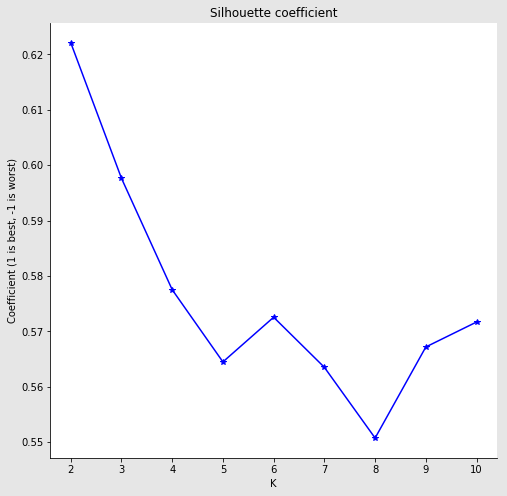

In [40]:
# KMeans with bike_id 342
training_feature = generatetraining(342)
siloutteplot(training_feature)

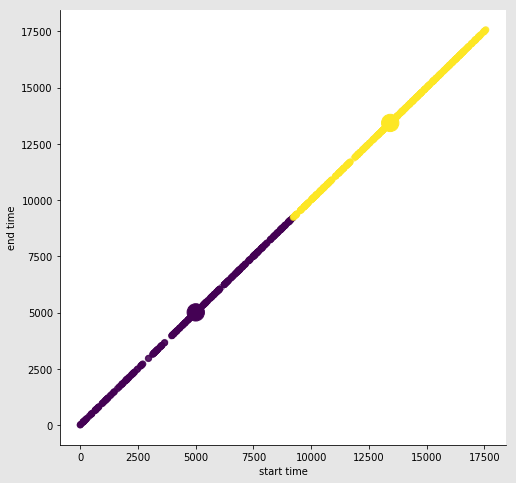

In [41]:
# The optimal K from the above plot is 2. And the clustering for bike id 342 is not that good.
clusterplot(2, training_feature)

From the above two exampels, the method is KMenas fails to find the lifecycle interval for all bikes. So we choose the statistical method to get a reasonal lifecycle interval based on the assumption that lifecycle interval is normal distribution.

### 1.2.2 Probability Value

In [42]:
def collectinterval(dataset):
    """Collect all trip intervals.
    """
    interval_list = []
    bikeid = set(dataset.bike_id.unique())
    for bike_id in bikeid:
        temp = dataset[dataset['bike_id'] == bike_id] 
        temp.loc[:,'start_date'] =pd.to_datetime(temp['start_date'].values)
        temp.loc[:,'end_date'] =pd.to_datetime(temp['end_date'].values)
        temp = temp.sort_values(by=['start_date'])
        for i in range(1, len(temp)):
            t = ((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'm')).astype(int)
            interval_list.append(t)
    return interval_list
interval_list = collectinterval(trip)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


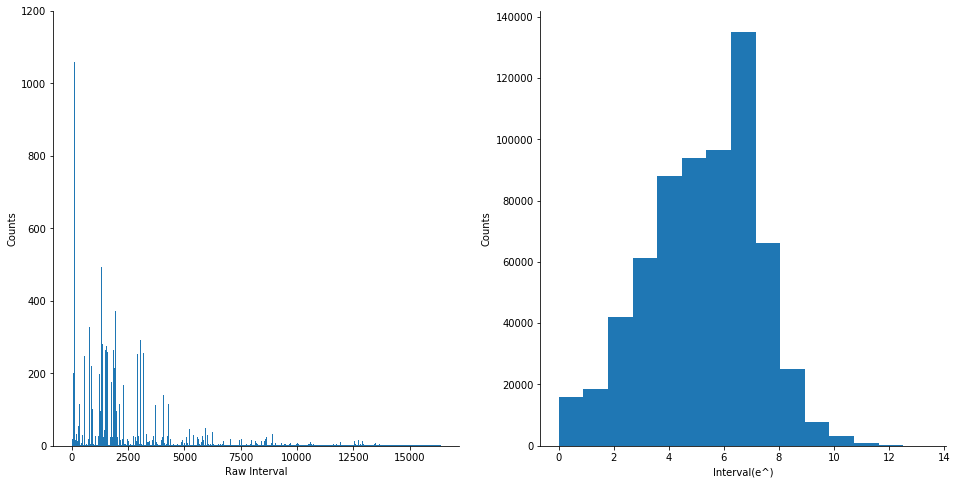

In [50]:
# Check the distribution of all intervals
# Distribution with raw data
plt.figure(figsize=(16, 8))
ax3 = plt.subplot(121)
labels, values = zip(*Counter(interval_list).items())
indexes = np.arange(len(labels))
ax3.bar(indexes,values, 1)
plt.xlabel('Raw Interval')
plt.ylabel('Counts')
ax3.set_ylim(0, 1200)
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')

## Distribution with log data 
interval_lg = np.log(np.array(interval_list))
interval_lg = interval_lg[~np.isnan(interval_lg)]
interval_lg = interval_lg[~np.isinf(interval_lg)]
ax4 = plt.subplot(122)
ax4.hist(interval_lg, bins=15)
plt.xlabel('Interval(e^)')
plt.ylabel('Counts')
ax4.spines['right'].set_color('none')
ax4.spines['top'].set_color('none')

In [51]:
# Calculate the up bound of interval. We get t ~= 7 and t2 ~= 4
t = np.mean(interval_lg) + 2*np.std(interval_lg)  # 95%
t2 = np.mean(interval_lg) + (1.644)*np.std(interval_lg) # 90%

In [53]:
def tempcovert(temp):
    """Group trips with the calculated interval
    """
    final_id_list = []
    bike_group = []
    counts = 0
    for i in range(len(temp)):
        old_id = temp.iloc[i].bike_id
        if i == 0:
            bike_group.append(str(old_id) +'_'+str(counts))
        elif i == len(temp)-1:
            bike_group.append(str(old_id) +'_'+str(counts)) 
            final_id = str(old_id) +'_'+str(counts) 
            final_id_list.append(final_id)
        else:
            if (((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'D')).astype(int) > 4 and
               temp.iloc[i].start_station_id != temp.iloc[i-1].end_station_id):
                counts += 1
            elif ((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'D')).astype(int) > 7:
                counts += 1
            bike_group.append(str(old_id) +'_'+str(counts))
    result = pd.DataFrame(bike_group, columns = ['bike_group'], index=temp.index)
    temp = pd.concat([temp, result], axis =1)
    return temp, final_id

def generatelifecycle(dataset):
    """Generate new dataset based on lifecycle.
    """
    new_pd = pd.DataFrame()
    finalid_list = []
    id_set = set(dataset.bike_id.unique())
    for bikeid in id_set:
        temp = dataset[dataset['bike_id'] == bikeid]
        temp.sort_values(by=['start_date'])
        temp['start_date'] =pd.to_datetime(temp['start_date'].values)
        temp['end_date'] =pd.to_datetime(temp['end_date'].values)
        temp, final_id = tempcovert(temp)
        new_pd = pd.concat([new_pd, temp])
        finalid_list.append(final_id)
    return new_pd, finalid_list

new_pd, finalid_list = generatelifecycle(trip)
new_pd_removelast = new_pd[~new_pd['bike_group'].isin(finalid_list)]
new_pd_removelast.to_csv('Dataset/lifecycle_final.csv')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 2 Data Analysis

## 2.1 Current Feature Analysis

### 2.1.1 Lifecycle VS Subscription Ratio

In [55]:
station['start_station_id'] = station['id']

# Get the duration for a lifecycle
duration = pd.DataFrame()
a = lifecycle[['bike_group', 'duration']].groupby(['bike_group']).sum()
duration['bike_group'] = a.index
duration['duration'] = a.duration.values

# Get the subscribe_type sum
subscriber = pd.DataFrame()
customer = pd.DataFrame()
b = lifecycle.loc[lifecycle.subscription_type=="Subscriber"][['bike_group', 'subscription_type']].groupby(['bike_group']).count()
c = lifecycle.loc[lifecycle.subscription_type=="Customer"][['bike_group', 'subscription_type']].groupby(['bike_group']).count()
subscriber['bike_group'] = b.index
subscriber['subscriber'] = b.subscription_type.values
customer['bike_group'] = c.index
customer['customer'] = c.subscription_type.values

# Get the trips count
trips = pd.DataFrame()
d = lifecycle[['bike_group', 'id']].groupby(['bike_group']).count()
trips['bike_group'] = d.index
trips['trips number'] = d.id.values

bdata = pd.merge(duration, subscriber, on="bike_group", how="left")
bdata = pd.merge(bdata, customer, on="bike_group", how="left")
bdata = bdata.fillna(0)
bdata = pd.merge(bdata, trips, on="bike_group", how="left")
bdata['total subscribe types'] = bdata['subscriber'] + bdata['customer']
bdata['subscriber ratio'] = bdata['subscriber']/bdata['total subscribe types']

# Merge geo 
bdata['start_station_id'] = lifecycle['start_station_id']
bdata = pd.merge(bdata, station[['start_station_id', 'lat', 'long']], on='start_station_id', how="left")

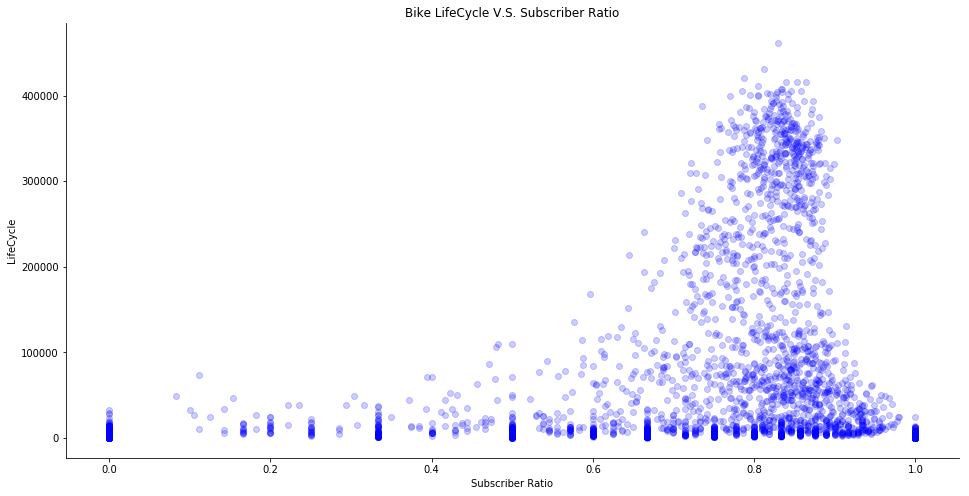

In [56]:
# First plot: Bike LifeCycle V.S. Subscriber Ratio
plt.figure(figsize=(16, 8))
ax5 = plt.subplot(111)
ax5.scatter(bdata['subscriber ratio'], bdata['duration'], color='b', alpha=0.2)
plt.xlabel('Subscriber Ratio')
plt.ylabel('LifeCycle')
plt.title('Bike LifeCycle V.S. Subscriber Ratio')
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

### 2.1.2 Lifecycle VS Trips Number

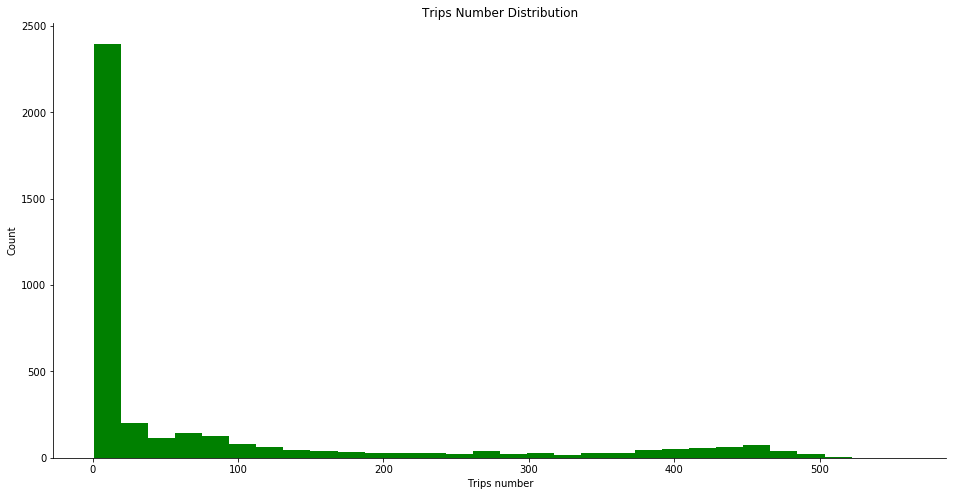

In [57]:
plt.figure(figsize=(16, 8))
ax6 = plt.subplot(111)
ax6.hist(bdata['trips number'], bins=30, color="green")
plt.xlabel('Trips number')
plt.ylabel('Count')
plt.title('Trips Number Distribution')
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

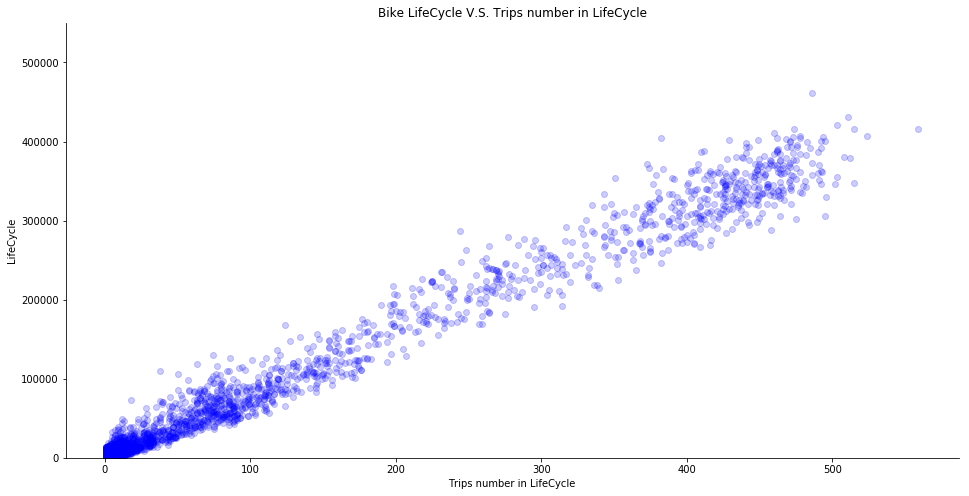

In [62]:
# Second plot: Bike LifeCycle V.S. Trips Number in LifeCycle
plt.figure(figsize=(16, 8))
ax7 = plt.subplot(111)
ax7.scatter(bdata['trips number'], bdata['duration'], color='b', alpha=0.2)
plt.xlabel('Trips number in LifeCycle')
plt.ylabel('LifeCycle')
plt.title('Bike LifeCycle V.S. Trips number in LifeCycle')
ax7.set_ylim(0, 550000)
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

### 2.1.3  Station VS Lifecycle

In [67]:
# Duration by Stations and Cities

# San Francisco Station Ids and Station Durations
san_francisco_station_ids = lifecycle.loc[lifecycle.city == 'San Francisco'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
san_francisco_station_durations = lifecycle.loc[lifecycle.city == 'San Francisco'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
san_francisco_station_durations = [x[0] for x in san_francisco_station_durations]

# Redwood City Station Ids and Station Durations
redwood_city_station_ids = lifecycle.loc[lifecycle.city == 'Redwood City'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
redwood_city_station_durations = lifecycle.loc[lifecycle.city == 'Redwood City'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
redwood_city_station_durations = [x[0] for x in redwood_city_station_durations]

# Palo Alto Station Ids and Station Durations
palo_alto_station_ids = lifecycle.loc[lifecycle.city == 'Palo Alto'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
palo_alto_station_durations = lifecycle.loc[lifecycle.city == 'Palo Alto'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
palo_alto_station_durations = [x[0] for x in palo_alto_station_durations]

# Mountain View Station Ids and Station Durations
mountain_view_station_ids = lifecycle.loc[lifecycle.city == 'Mountain View'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
mountain_view_station_durations = lifecycle.loc[lifecycle.city == 'Mountain View'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
mountain_view_station_durations = [x[0] for x in mountain_view_station_durations]

# San Jose Station Ids and Station Durations
san_jose_station_ids = lifecycle.loc[lifecycle.city == 'San Jose'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
san_jose_station_durations = lifecycle.loc[lifecycle.city == 'San Jose'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
san_jose_station_durations = [x[0] for x in san_jose_station_durations]

San Francisco Stations Number is: 35
Redwood City Stations Number is: 7
Palo Alto Stations Number is: 5
Mountain View Stations Number is: 7
San Jose Stations Number is: 16


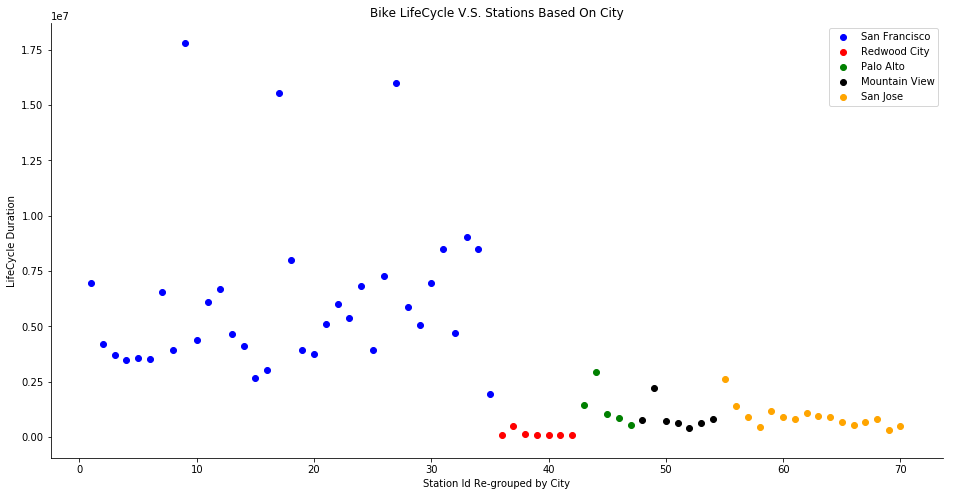

In [68]:
# Scatter plot by City. (Reassign station id based on city in order to have some city stations group together in plot.)
plt.figure(figsize=(16, 8))
ax8 = plt.subplot(111)
# Plot 
print("San Francisco Stations Number is: {0}".format(len(san_francisco_station_ids)))
print("Redwood City Stations Number is: {0}".format(len(redwood_city_station_ids)))
print("Palo Alto Stations Number is: {0}".format(len(palo_alto_station_ids)))
print("Mountain View Stations Number is: {0}".format(len(mountain_view_station_ids)))
print("San Jose Stations Number is: {0}".format(len(san_jose_station_ids)))

ax8.scatter(list(range(1, 36)), san_francisco_station_durations, color='blue', label="San Francisco")
ax8.scatter(list(range(36, 43)), redwood_city_station_durations, color='red', label="Redwood City")
ax8.scatter(list(range(43, 48)), palo_alto_station_durations, color='green', label="Palo Alto")
ax8.scatter(list(range(48, 55)), mountain_view_station_durations, color='black', label="Mountain View")
ax8.scatter(list(range(55, 71)), san_jose_station_durations, color='orange', label="San Jose")
plt.xlabel('Station Id Re-grouped by City')
plt.ylabel('LifeCycle Duration')
plt.title('Bike LifeCycle V.S. Stations Based On City')
ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)
plt.legend()

In [63]:
# Heat Map, Check folder 'Html/heatmap.html'
heatMapData = pd.DataFrame()
d = bdata[['duration', 'lat', 'long']].groupby(['lat', 'long']).sum()
lats = []
longs = []
for e in d.index.values.tolist():
    lats.append(e[0])
    longs.append(e[1])
heatMapData['lat'] = lats
heatMapData['long'] = longs
heatMapData['duration'] = d.duration.values

In [66]:
data = []
for index, row in heatMapData.iterrows():
    temp = {}
    temp['lat'] = row['lat']
    temp['lng'] = row['long']
    temp['count'] = row['duration']
    data.append(temp)

#### 2.1.3.1 Overview
![Overview](images/Duration_Overview.jpeg)

#### 2.1.3.2 San Francisco
![San_Francisco](images/Duration_San_Francisco.jpeg)

#### 2.1.3.3 Redwood City
![Redwood_City](images/Duration_Redwood_City.jpeg)

#### 2.1.3.4 Palo Alto
![Palo_Alto](images/Duration_Palo_Alto.jpeg)

#### 2.1.3.5 Mountain View
![Mountain_View](images/Duration_Mountain_View.jpeg)

#### 2.1.3.6 San Jose
![San_Jose](images/Duration_San_Jose.jpeg)

### 2.1.4 Station VS Crime

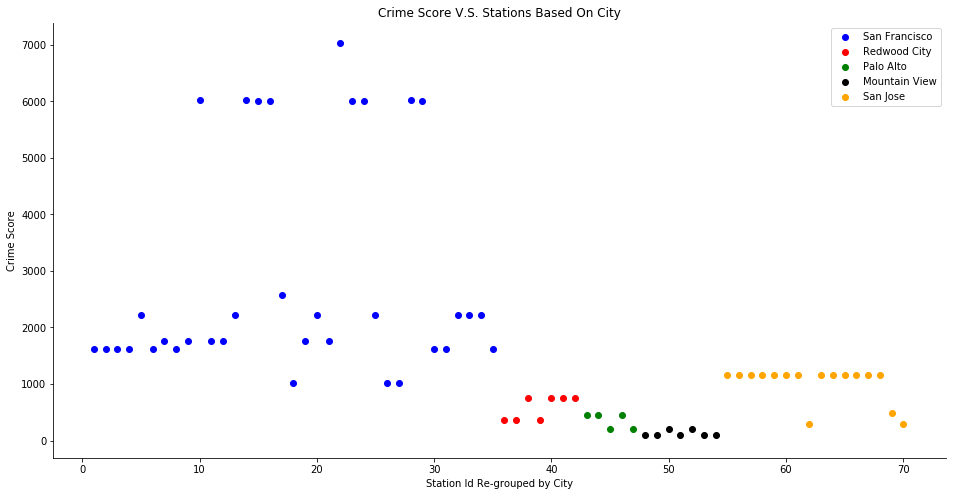

In [69]:
# stations_crimeScore.csv
crime = pd.read_csv('Dataset/stations_crimeScore.csv')
plt.figure(figsize=(16, 8))
ax9 = plt.subplot(111)
crime
ax9.scatter(list(range(1, 36)), crime.loc[crime.city == 'San Francisco']['crime_score'], color='blue', label="San Francisco")
ax9.scatter(list(range(36, 43)), crime.loc[crime.city == 'Redwood City']['crime_score'], color='red', label="Redwood City")
ax9.scatter(list(range(43, 48)), crime.loc[crime.city == 'Palo Alto']['crime_score'], color='green', label="Palo Alto")
ax9.scatter(list(range(48, 55)), crime.loc[crime.city == 'Mountain View']['crime_score'], color='black', label="Mountain View")
ax9.scatter(list(range(55, 71)), crime.loc[crime.city == 'San Jose']['crime_score'], color='orange', label="San Jose")
plt.xlabel('Station Id Re-grouped by City')
plt.ylabel('Crime Score')
plt.title('Crime Score V.S. Stations Based On City')
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
plt.legend()

#### 2.1.4.1 Crime HeatMap Overview
![Overview](images/Crime_Overview.jpeg)

#### 2.1.4.2 San Francisco
![San_Francisco](images/Crime_San_Francisco.jpeg)

#### 2.1.4.3 Redwood City
![Redwood_City](images/Crime_Redwood_City.jpeg)

#### 2.1.4.4 Palo Alto
![Palo_Alto](images/Crime_Palo_Alto.jpeg)

#### 2.1.4.5 Mountain View
![Mountain_View](images/Crime_Mountain_View.jpeg)

#### 2.1.4.6 San Jose
![San_Jose](images/Crime_San_Jose.jpeg)

### 2.1.5 Lifecycle VS Period

In [71]:
lifecycle['start_date'] = pd.to_datetime(lifecycle['start_date'])
lifecycle['end_date'] = pd.to_datetime(lifecycle['end_date'])

times = list(range(8, 21, 4))
labels = ['morning', 'afternoon', 'evening', 'night']
periods = dict(zip(times, labels))
def period(row):
    visit_start = {'hour': row.start_date.hour, 'min': row.start_date.minute} # get hour, min of visit start
    visit_end = {'hour': row.end_date.hour, 'min': row.end_date.minute} # get hour, min of visit end
    for period_start, label in periods.items():
        period_end = period_start + 4
        if period_start <= visit_start['hour'] < period_end:
            if period_start <= visit_end['hour'] < period_end or (period_end - visit_start['hour']) * 60 - visit_start['min'] > (visit_end['hour'] - period_end) * 60 + visit_end['min']:
                return label
            else:
                return periods[period_end] # assign label of following period  
lifecycle['period'] = lifecycle.apply(period, axis=1)

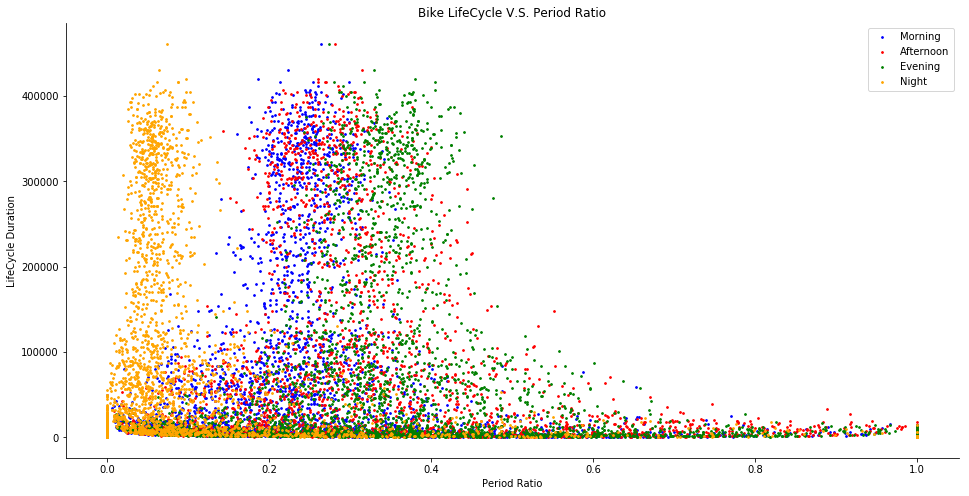

In [73]:
period = pd.DataFrame()
d = lifecycle[['bike_group', 'period', 'duration']].groupby(['bike_group', 'period']).sum()
bike_ids = []
p = []
for e in d.index.values:
    bike_ids.append(e[0])
    p.append(e[1])
period['bike_group'] = bike_ids
period['period'] = p
period['duration'] = [x[0] for x in d.values.tolist()]

# Calculate morning duration rate compared to total duration
morning_duration = pd.merge(duration, period.loc[period.period == 'morning'], on='bike_group', how="left")
morning_duration['period'] = morning_duration['period'].fillna('morning')
morning_duration['duration_y'] = morning_duration['duration_y'].fillna(0)
morning_duration['morning rate'] = morning_duration['duration_y']/morning_duration['duration_x']

# Calculate afternoon duration rate compared to total duration
afternoon_duration = pd.merge(duration, period.loc[period.period == 'afternoon'], on='bike_group', how="left")
afternoon_duration['period'] = afternoon_duration['period'].fillna('afternoon')
afternoon_duration['duration_y'] = afternoon_duration['duration_y'].fillna(0)
afternoon_duration['afternoon rate'] = afternoon_duration['duration_y']/afternoon_duration['duration_x']

# Calculate evening duration rate compared to total duration
evening_duration = pd.merge(duration, period.loc[period.period == 'evening'], on='bike_group', how="left")
evening_duration['period'] = evening_duration['period'].fillna('evening')
evening_duration['duration_y'] = evening_duration['duration_y'].fillna(0)
evening_duration['evening rate'] = evening_duration['duration_y']/evening_duration['duration_x']

# Calculate night duration rate compared to total duration
night_duration = pd.merge(duration, period.loc[period.period == 'night'], on='bike_group', how="left")
night_duration['period'] = night_duration['period'].fillna('night')
night_duration['duration_y'] = night_duration['duration_y'].fillna(0)
night_duration['night rate'] = night_duration['duration_y']/night_duration['duration_x']

plt.figure(figsize=(16, 8))
ax10 = plt.subplot(111)
ax10.scatter(morning_duration['morning rate'], morning_duration['duration_x'], color='blue', alpha=1, label="Morning", s=3)
ax10.scatter(afternoon_duration['afternoon rate'], afternoon_duration['duration_x'], color='red', alpha=1, label="Afternoon", s=3)
ax10.scatter(evening_duration['evening rate'], evening_duration['duration_x'], color='green', alpha=1, label="Evening", s=3)
ax10.scatter(night_duration['night rate'], night_duration['duration_x'], color='orange', alpha=1, label="Night", s=3)

plt.xlabel('Period Ratio')
plt.ylabel('LifeCycle Duration')
plt.title('Bike LifeCycle V.S. Period Ratio')
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
plt.legend()

### 2.1.6 Lifecycle VS Parked Period


## 2.2 Weather 

## 2.3 Income

## 2.4 Education

## 2.5 Crime

## 2.6 Finalize Dataset

# 3 Modeling

## 3.1 Linear Regression

### 3.1.1 Fitting Model

### 3.1.2 Error Analysis

## 3.2 Random Forest

### 3.2.1 Fitting Model

### 3.2.2 Error Analysis

## 3.3 Neural Network

### 3.3.1 Fitting Model

### 3.3.2 Error Analysis

# 4 Conclusion